In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import pickle
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=4, releaselevel='final', serial=0)
matplotlib 2.1.2
numpy 1.19.1
pandas 0.22.0
sklearn 0.19.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
# 从本地保存数据文件加载数据
with open(file='data/california_housing.pkl', mode='rb') as f:
    housing=pickle.load(f)
# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# 此处采用fit_transform是因为，该函数可以将训练集的均值和方差记录下来，这样在验证集和测试集可以保持一致，这样也就保证了数据是同分布的，模型的构建和训练才会有效
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [11]:
# RandomizedSearchCV
# 1. 转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                     activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

sklearn_model = keras.wrappers.scikit_learn.KerasRegressor(
    build_fn = build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
history = sklearn_model.fit(x_train_scaled, y_train,
                            epochs = 100,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)

Epoch 1/100
363/363 [==============================] - 1s 3ms/step - loss: 0.9231 - val_loss: 0.7247
Epoch 2/100
363/363 [==============================] - 1s 3ms/step - loss: 0.6358 - val_loss: 0.6265
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5599 - val_loss: 0.5749
Epoch 4/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5305 - val_loss: 0.5459
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5260 - val_loss: 0.5237
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.5040 - val_loss: 0.4979
Epoch 7/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4748 - val_loss: 0.4988
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4559 - val_loss: 0.4744
Epoch 9/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4457 - val_loss: 0.4685
Epoch 10/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4471 - val_lo

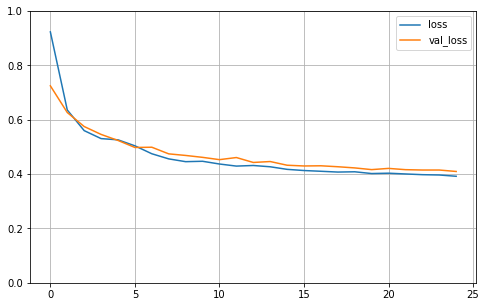

In [12]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)


In [14]:
from scipy.stats import reciprocal
# f(x) = 1/(x*log(b/a)) a <= x <= b

param_distribution = {
    "hidden_layers":[1, 2, 3, 4],
    "layer_size": np.arange(1, 100),
    "learning_rate": reciprocal(1e-4, 1e-2),
}

from sklearn.model_selection import RandomizedSearchCV

random_search_cv = RandomizedSearchCV(sklearn_model,
                                     param_distribution,
                                     n_iter = 10,
                                     cv = 3, # 采用几折交叉验证
                                     n_jobs = 1)
random_search_cv.fit(x_train_scaled, y_train, epochs = 100,
                    validation_data = (x_valid_scaled, y_valid),
                    callbacks = callbacks)

# cross_validation: 训练集分成n份，n-1训练，最后一份验证.

Epoch 1/100
242/242 [==============================] - 1s 4ms/step - loss: 1.4927 - val_loss: 0.7365
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6287 - val_loss: 0.6212
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5656 - val_loss: 0.5695
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5246 - val_loss: 0.5289
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4929 - val_loss: 0.4969
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4656 - val_loss: 0.4695
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4453 - val_loss: 0.4490
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4257 - val_loss: 0.4309
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4101 - val_loss: 0.4176
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3981 - val_lo

242/242 [==============================] - 0s 2ms/step - loss: 0.3076
Epoch 1/100
242/242 [==============================] - 1s 4ms/step - loss: 4.7382 - val_loss: 4.2153
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 3.5835 - val_loss: 3.2197
Epoch 3/100
242/242 [==============================] - 1s 4ms/step - loss: 2.8034 - val_loss: 2.5456
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 2.2809 - val_loss: 2.0953
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 1.9207 - val_loss: 1.7798
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 1.6673 - val_loss: 1.5579
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 1.4855 - val_loss: 1.3975
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 1.3485 - val_loss: 1.2769
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 1.2432 - val_loss: 1.1857
Epoch 10/100
242/242 

242/242 [==============================] - 1s 4ms/step - loss: 0.5574 - val_loss: 0.5898
Epoch 81/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5552 - val_loss: 0.5874
Epoch 82/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5529 - val_loss: 0.5850
Epoch 83/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5508 - val_loss: 0.5827
Epoch 84/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5486 - val_loss: 0.5804
Epoch 85/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5465 - val_loss: 0.5781
Epoch 86/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5444 - val_loss: 0.5759
Epoch 87/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5423 - val_loss: 0.5736
Epoch 88/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5403 - val_loss: 0.5714
Epoch 89/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5383 - val_loss: 

242/242 [==============================] - 1s 4ms/step - loss: 0.5321 - val_loss: 0.5737
Epoch 60/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5300 - val_loss: 0.5713
Epoch 61/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5279 - val_loss: 0.5690
Epoch 62/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5259 - val_loss: 0.5667
Epoch 63/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5239 - val_loss: 0.5645
Epoch 64/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5219 - val_loss: 0.5623
Epoch 65/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5200 - val_loss: 0.5602
Epoch 66/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5181 - val_loss: 0.5580
Epoch 67/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5163 - val_loss: 0.5559
Epoch 68/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5144 - val_loss: 

242/242 [==============================] - 1s 3ms/step - loss: 0.5844 - val_loss: 0.6483
Epoch 64/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5822 - val_loss: 0.6458
Epoch 65/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5801 - val_loss: 0.6435
Epoch 66/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5780 - val_loss: 0.6412
Epoch 67/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5759 - val_loss: 0.6389
Epoch 68/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5738 - val_loss: 0.6366
Epoch 69/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5717 - val_loss: 0.6343
Epoch 70/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5696 - val_loss: 0.6321
Epoch 71/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5676 - val_loss: 0.6298
Epoch 72/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5656 - val_loss: 

242/242 [==============================] - 1s 4ms/step - loss: 3.8243 - val_loss: 0.7868
Epoch 2/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5798 - val_loss: 0.5440
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4656 - val_loss: 0.4624
Epoch 4/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4184 - val_loss: 0.4284
Epoch 5/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3948 - val_loss: 0.4114
Epoch 6/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3828 - val_loss: 0.4014
Epoch 7/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3751 - val_loss: 0.3964
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3699 - val_loss: 0.3862
Epoch 9/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3655 - val_loss: 0.3819
Epoch 10/100
242/242 [==============================] - 1s 3ms/step - loss: 0.3622 - val_loss: 0.3830
E

242/242 [==============================] - 1s 4ms/step - loss: 0.4169 - val_loss: 0.4463
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3977 - val_loss: 0.4424
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3890 - val_loss: 0.4245
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3754 - val_loss: 0.4058
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3666 - val_loss: 0.3987
Epoch 11/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3663 - val_loss: 0.3923
Epoch 12/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3654 - val_loss: 0.3893
Epoch 13/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3592 - val_loss: 0.3892
Epoch 14/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3540 - val_loss: 0.3803
Epoch 15/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3488 - val_loss: 0.3

242/242 [==============================] - 1s 4ms/step - loss: 0.4674 - val_loss: 0.5034
Epoch 6/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4451 - val_loss: 0.4798
Epoch 7/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4307 - val_loss: 0.4696
Epoch 8/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4204 - val_loss: 0.4540
Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4104 - val_loss: 0.4472
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.4026 - val_loss: 0.4353
Epoch 11/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3951 - val_loss: 0.4293
Epoch 12/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3897 - val_loss: 0.4235
Epoch 13/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3842 - val_loss: 0.4186
Epoch 14/100
242/242 [==============================] - 1s 4ms/step - loss: 0.3798 - val_loss: 0.41

Epoch 9/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6715 - val_loss: 0.7107
Epoch 10/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6412 - val_loss: 0.6826
Epoch 11/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6180 - val_loss: 0.6602
Epoch 12/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5997 - val_loss: 0.6419
Epoch 13/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5852 - val_loss: 0.6265
Epoch 14/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5739 - val_loss: 0.6146
Epoch 15/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5645 - val_loss: 0.6038
Epoch 16/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5564 - val_loss: 0.5946
Epoch 17/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5493 - val_loss: 0.5864
Epoch 18/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5431 

242/242 [==============================] - 1s 4ms/step - loss: 0.5296 - val_loss: 0.5871
Epoch 46/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5271 - val_loss: 0.5846
Epoch 47/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5246 - val_loss: 0.5816
Epoch 48/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5221 - val_loss: 0.5787
Epoch 49/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5195 - val_loss: 0.5755
Epoch 50/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5171 - val_loss: 0.5729
Epoch 51/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5144 - val_loss: 0.5701
Epoch 52/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5120 - val_loss: 0.5674
Epoch 53/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5096 - val_loss: 0.5646
Epoch 54/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5071 - val_loss: 

242/242 [==============================] - 1s 4ms/step - loss: 0.6044 - val_loss: 0.6279
Epoch 29/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6011 - val_loss: 0.6251
Epoch 30/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5981 - val_loss: 0.6222
Epoch 31/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5952 - val_loss: 0.6194
Epoch 32/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5924 - val_loss: 0.6168
Epoch 33/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5898 - val_loss: 0.6145
Epoch 34/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5872 - val_loss: 0.6124
Epoch 35/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5848 - val_loss: 0.6100
Epoch 36/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5825 - val_loss: 0.6079
Epoch 37/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5802 - val_loss: 

242/242 [==============================] - 1s 3ms/step - loss: 0.6402 - val_loss: 0.6904
Epoch 67/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6379 - val_loss: 0.6882
Epoch 68/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6358 - val_loss: 0.6860
Epoch 69/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6335 - val_loss: 0.6842
Epoch 70/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6314 - val_loss: 0.6820
Epoch 71/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6293 - val_loss: 0.6798
Epoch 72/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6271 - val_loss: 0.6779
Epoch 73/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6250 - val_loss: 0.6757
Epoch 74/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6229 - val_loss: 0.6737
Epoch 75/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6208 - val_loss: 

Epoch 17/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7954 - val_loss: 0.8189
Epoch 18/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7746 - val_loss: 0.7994
Epoch 19/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7567 - val_loss: 0.7825
Epoch 20/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7413 - val_loss: 0.7679
Epoch 21/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7278 - val_loss: 0.7551
Epoch 22/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7160 - val_loss: 0.7438
Epoch 23/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7055 - val_loss: 0.7337
Epoch 24/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6960 - val_loss: 0.7246
Epoch 25/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6876 - val_loss: 0.7165
Epoch 26/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6799

242/242 [==============================] - 1s 4ms/step - loss: 0.7175 - val_loss: 0.7661
Epoch 18/100
242/242 [==============================] - 1s 4ms/step - loss: 0.7065 - val_loss: 0.7557
Epoch 19/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6968 - val_loss: 0.7465
Epoch 20/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6882 - val_loss: 0.7382
Epoch 21/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6805 - val_loss: 0.7308
Epoch 22/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6735 - val_loss: 0.7241
Epoch 23/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6672 - val_loss: 0.7179
Epoch 24/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6613 - val_loss: 0.7122
Epoch 25/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6559 - val_loss: 0.7068
Epoch 26/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6508 - val_loss: 

242/242 [==============================] - 1s 3ms/step - loss: 0.6737 - val_loss: 0.7542
Epoch 31/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6691 - val_loss: 0.7499
Epoch 32/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6648 - val_loss: 0.7457
Epoch 33/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6606 - val_loss: 0.7416
Epoch 34/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6565 - val_loss: 0.7375
Epoch 35/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6526 - val_loss: 0.7336
Epoch 36/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6488 - val_loss: 0.7298
Epoch 37/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6450 - val_loss: 0.7260
Epoch 38/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6414 - val_loss: 0.7222
Epoch 39/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6379 - val_loss: 

242/242 [==============================] - 1s 3ms/step - loss: 0.6553 - val_loss: 0.6704
Epoch 24/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6501 - val_loss: 0.6656
Epoch 25/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6452 - val_loss: 0.6611
Epoch 26/100
242/242 [==============================] - 1s 4ms/step - loss: 0.6406 - val_loss: 0.6569
Epoch 27/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6361 - val_loss: 0.6528
Epoch 28/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6320 - val_loss: 0.6488
Epoch 29/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6280 - val_loss: 0.6451
Epoch 30/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6240 - val_loss: 0.6414
Epoch 31/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6201 - val_loss: 0.6378
Epoch 32/100
242/242 [==============================] - 1s 3ms/step - loss: 0.6164 - val_loss: 

242/242 [==============================] - 1s 3ms/step - loss: 0.5115 - val_loss: 0.5481
Epoch 48/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5094 - val_loss: 0.5459
Epoch 49/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5074 - val_loss: 0.5439
Epoch 50/100
242/242 [==============================] - 1s 4ms/step - loss: 0.5055 - val_loss: 0.5420
Epoch 51/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5038 - val_loss: 0.5401
Epoch 52/100
242/242 [==============================] - 1s 3ms/step - loss: 0.5021 - val_loss: 0.5384
Epoch 53/100
242/242 [==============================] - 0s 2ms/step - loss: 0.4996
Epoch 1/100
242/242 [==============================] - 1s 4ms/step - loss: 6.6341 - val_loss: 4.8876
Epoch 2/100
242/242 [==============================] - 1s 4ms/step - loss: 3.6833 - val_loss: 3.1777
Epoch 3/100
242/242 [==============================] - 1s 3ms/step - loss: 2.5532 - val_loss: 2.4009
Epoch 4/100
242

Epoch 19/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4836 - val_loss: 0.5009
Epoch 20/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4791 - val_loss: 0.4965
Epoch 21/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4744 - val_loss: 0.4927
Epoch 22/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4710 - val_loss: 0.4878
Epoch 23/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4671 - val_loss: 0.4843
Epoch 24/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4637 - val_loss: 0.4784
Epoch 25/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4604 - val_loss: 0.4743
Epoch 26/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4577 - val_loss: 0.4713
Epoch 27/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4548 - val_loss: 0.4683
Epoch 28/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4521

242/242 [==============================] - 1s 3ms/step - loss: 0.5062 - val_loss: 0.5551
Epoch 14/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4981 - val_loss: 0.5435
Epoch 15/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4919 - val_loss: 0.5355
Epoch 16/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4859 - val_loss: 0.5286
Epoch 17/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4798 - val_loss: 0.5233
Epoch 18/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4748 - val_loss: 0.5175
Epoch 19/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4696 - val_loss: 0.5111
Epoch 20/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4657 - val_loss: 0.5072
Epoch 21/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4616 - val_loss: 0.5024
Epoch 22/100
242/242 [==============================] - 1s 3ms/step - loss: 0.4585 - val_loss: 

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f1969364fd0>,
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'hidden_layers': [1, 2, 3, 4], 'layer_size': array([ 1,  2, ..., 98, 99]), 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f1808143978>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [13]:
# 查看reciprocal分布的取值情况
from scipy.stats import reciprocal
reciprocal.rvs(1e-4, 1e-2, size=10)

array([0.00446622, 0.00261507, 0.00093575, 0.00029992, 0.00771443,
       0.00031126, 0.00012384, 0.00140246, 0.00099059, 0.0019329 ])

In [15]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 4, 'layer_size': 69, 'learning_rate': 0.0030034154155925037}
-0.3358098069826762


In [16]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 2ms/step - loss: 0.3287


0.32874101400375366